In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import gc

In [2]:
df_build = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv')
df_weather_train = pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv')
df_train = pd.read_csv('../input/ashrae-energy-prediction/train.csv')

df_weather_test = pd.read_csv('../input/ashrae-energy-prediction/weather_test.csv')
df_test = pd.read_csv('../input/ashrae-energy-prediction/test.csv')

In [3]:
df_build.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [4]:
df_weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [5]:
df_train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [6]:
print('Building Metadata', df_build.shape)
print('Train Data', df_train.shape)
print('Weather Train Data', df_weather_train.shape)

print('Test Data', df_test.shape)
print('Weather Test Data', df_weather_test.shape)

Building Metadata (1449, 6)
Train Data (20216100, 4)
Weather Train Data (139773, 9)
Test Data (41697600, 4)
Weather Test Data (277243, 9)


In [7]:
df_train.dtypes

building_id        int64
meter              int64
timestamp         object
meter_reading    float64
dtype: object

In [8]:
df_weather_train.dtypes

site_id                 int64
timestamp              object
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtype: object

Let's change the datatype of timestamp column to datetime format

In [9]:
def change_dtype(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
    return df

In [10]:
df_train = change_dtype(df_train)
df_weather_train = change_dtype(df_weather_train)
df_test = change_dtype(df_test)
df_weather_test = change_dtype(df_weather_test)

In [11]:
df_train = df_train.merge(df_build, on='building_id', how='left')
df_train = df_train.merge(df_weather_train, on=['site_id', 'timestamp'], how='left')

In [12]:
df_test = df_test.merge(df_build, on='building_id', how='left')
df_test = df_test.merge(df_weather_test, on=['site_id', 'timestamp'], how='left')

In [13]:
del df_build, df_weather_test
gc.collect()

11

In [14]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [15]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 1041.10 Mb (60.3% reduction)
Mem. usage decreased to 2147.36 Mb (60.3% reduction)


In [16]:
df_weather_train = reduce_mem_usage(df_weather_train)

Mem. usage decreased to  3.07 Mb (68.1% reduction)


In [17]:
df_train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


## Let's Proceed ahead with EDA

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
color = sns.color_palette()
sns.set_style("darkgrid")

In [19]:
df_train.shape

(20216100, 16)

__Dataset is huge we have around 20M datapoints__

In [20]:
df_train.isna().sum()

building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built            12127645
floor_count           16709167
air_temperature          96658
cloud_coverage         8825365
dew_temperature         100140
precip_depth_1_hr      3749023
sea_level_pressure     1231669
wind_direction         1449048
wind_speed              143676
dtype: int64

We can see there are some features whose null count is quite high, we will deal with them later

In [21]:
len(df_train['building_id'].value_counts())

1449

We have the data for __1449__ buildings 

In [22]:
print(f"Max number of entries for is for building {df_train['building_id'].value_counts().keys()[0]}: ", df_train['building_id'].value_counts().values[0])
print(f"Min number of entries for is for building {df_train['building_id'].value_counts().keys()[-1]}: ", df_train['building_id'].value_counts().values[-1])

Max number of entries for is for building 1298:  35136
Min number of entries for is for building 403:  479


In [23]:
print("Data in the train set is from:", df_train['timestamp'].min())
print("Data in the train set is till:", df_train['timestamp'].max())

Data in the train set is from: 2016-01-01 00:00:00
Data in the train set is till: 2016-12-31 23:00:00


So we have one year of data in our train set.

#### For test set

In [24]:
df_test['building_id'].value_counts()

1258    70080
1241    70080
1331    70080
1301    70080
1298    70080
        ...  
669     17520
668     17520
667     17520
666     17520
0       17520
Name: building_id, Length: 1449, dtype: int64

In [25]:
print(f"Max number of entries for is for building {df_test['building_id'].value_counts().keys()[0]}: ", df_test['building_id'].value_counts().values[0])
print(f"Min number of entries for is for building {df_test['building_id'].value_counts().keys()[-1]}: ", df_test['building_id'].value_counts().values[-1])
print(f"Data in the train set is from:", df_test['timestamp'].min())
print(f"Data in the train set is till:", df_test['timestamp'].max())

Max number of entries for is for building 1258:  70080
Min number of entries for is for building 0:  17520
Data in the train set is from: 2017-01-01 00:00:00
Data in the train set is till: 2018-12-31 23:00:00


The test set has 2 years of data

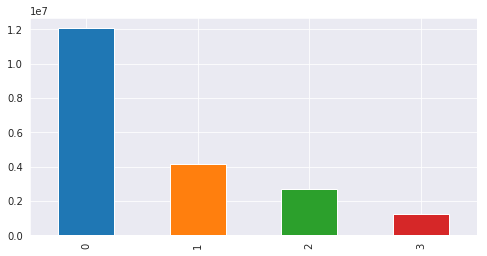

In [26]:
df_train['meter'].value_counts().plot.bar(figsize=(8,4), color=color)
plt.show()

We can see most ereadings is for __Electricity meter__ followed by __Chilledwater, Steam and Hotwater__.

Let's see the distribution of different meter readings across the dataset

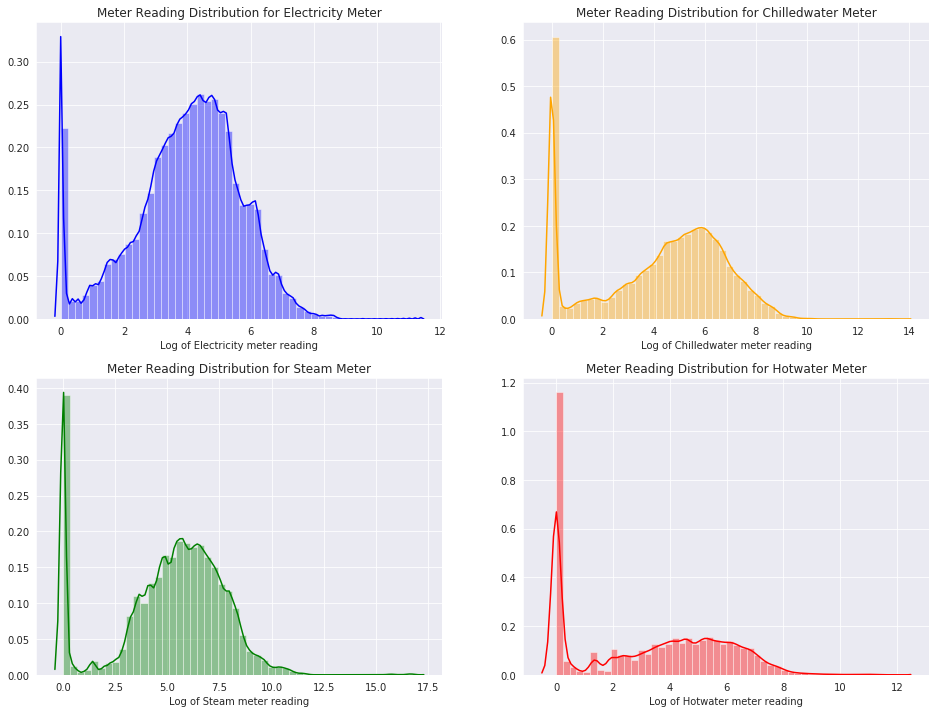

In [27]:
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(221)
sns.distplot(np.log1p(df_train[df_train['meter'] == 0]['meter_reading'].values),color='blue',ax=ax1, axlabel="Log of Electricity meter reading")
ax2 = fig.add_subplot(222)
sns.distplot(np.log1p(df_train[df_train['meter'] == 1]['meter_reading'].values),color='orange',ax=ax2, axlabel="Log of Chilledwater meter reading")
ax3 = fig.add_subplot(223)
sns.distplot(np.log1p(df_train[df_train['meter'] == 2]['meter_reading'].values),color='green',ax=ax3, axlabel="Log of Steam meter reading")
ax4 = fig.add_subplot(224)
sns.distplot(np.log1p(df_train[df_train['meter'] == 3]['meter_reading'].values),color='red',ax=ax4, axlabel="Log of Hotwater meter reading")

ax1.title.set_text('Meter Reading Distribution for Electricity Meter')
ax2.title.set_text('Meter Reading Distribution for Chilledwater Meter')
ax3.title.set_text('Meter Reading Distribution for Steam Meter')
ax4.title.set_text('Meter Reading Distribution for Hotwater Meter')

plt.show()

#### Let's check number of meters buildings are having

In [28]:
df_train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [29]:
df_temp = df_train.groupby(['building_id']).agg({"meter": ["nunique", "count"]})
df_temp.columns = ["_".join(i) for i in df_temp.columns.ravel()]

In [30]:
df_temp.sample(5)

,meter_nunique,meter_count
building_id,,
696,1,8784
665,1,8784
957,3,26297
847,1,7655
1080,3,26306


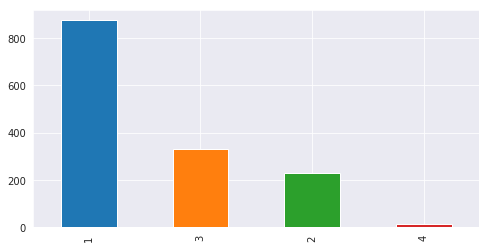

In [31]:
df_temp['meter_nunique'].value_counts().plot.bar(figsize=(8,4), color=color)
plt.show()

<b> Most of the buildings have only 1 type of meter

In [32]:
df_temp[df_temp['meter_nunique']==4]

,meter_nunique,meter_count
building_id,,
1232,4,34131
1241,4,35116
1249,4,35136
1258,4,31967
1259,4,35099
1293,4,33714
1294,4,35108
1295,4,35108
1296,4,35115


<b> Let's check energy consumption of some of the buildings to find energy consumtion is following a similar pattern</b>
* We will take building 1258 as it has the maximum number of entries in the dataset and 1331

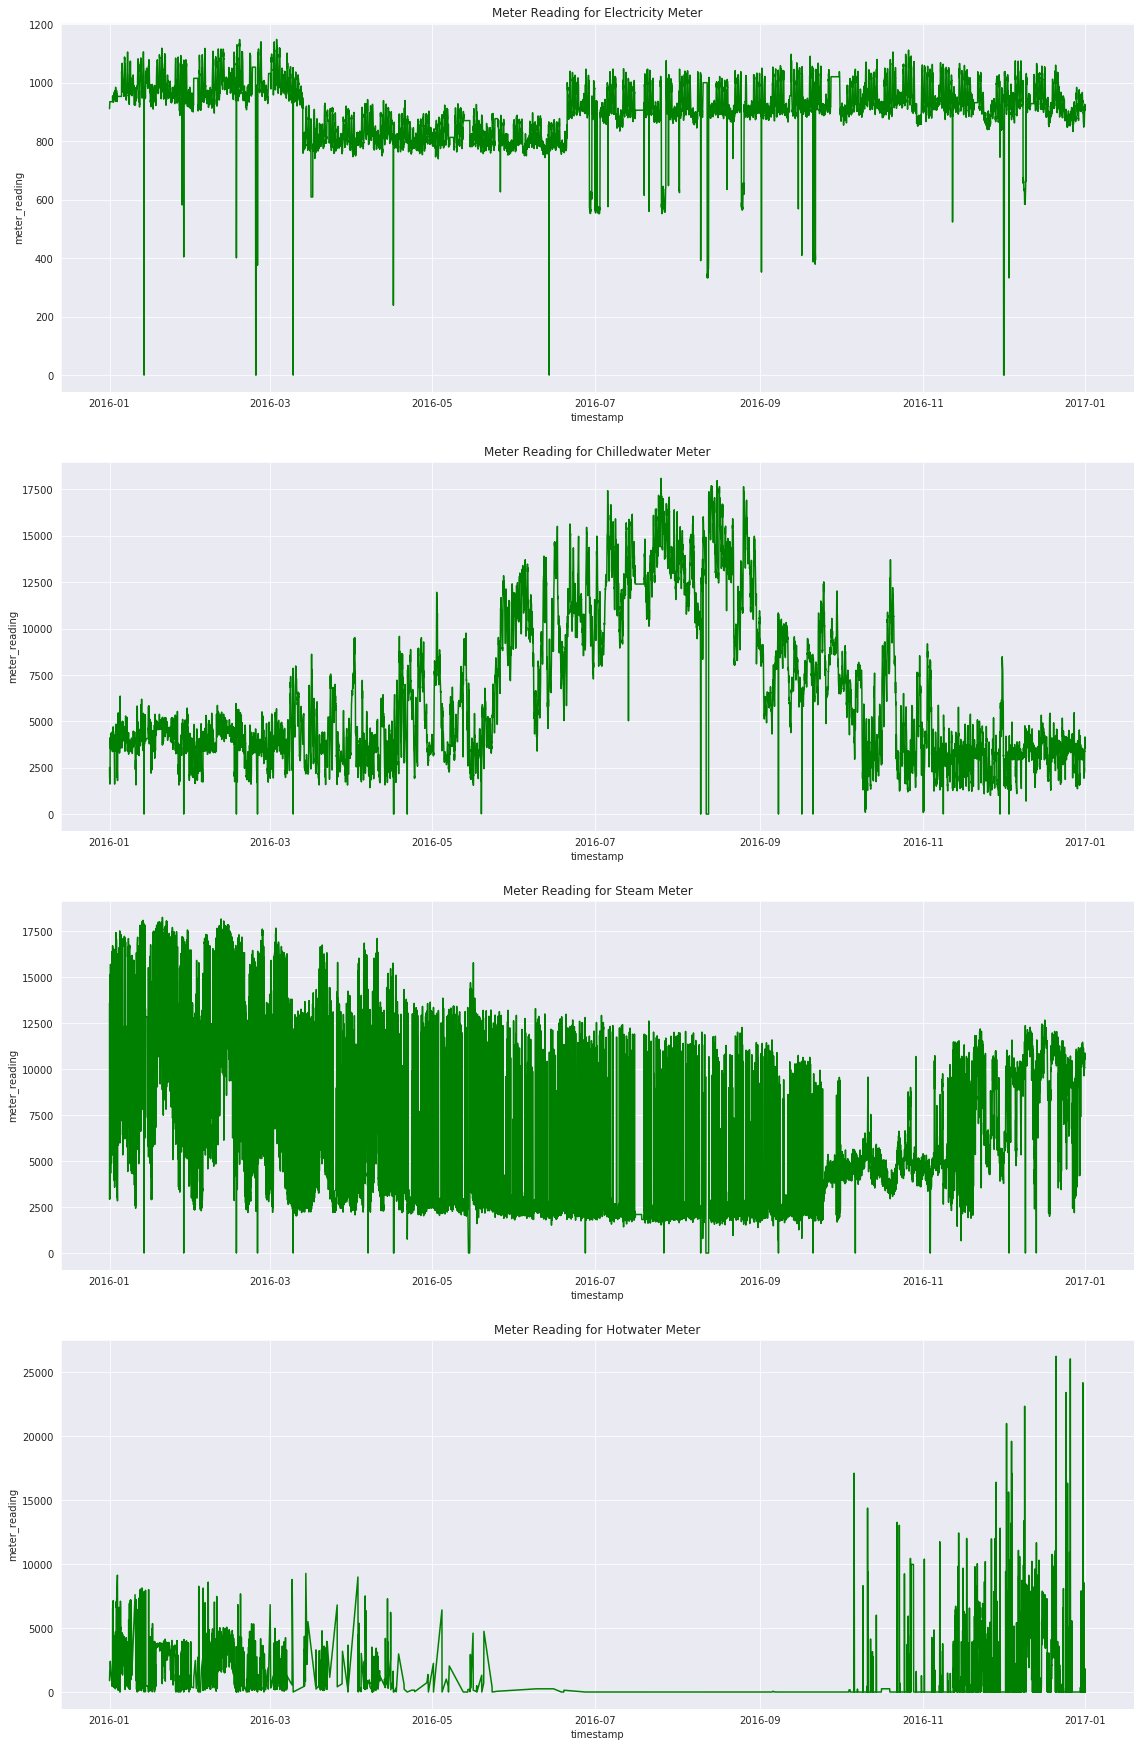

In [33]:
df_temp = df_train[df_train['building_id']==1258]
fig = plt.figure(figsize=(16, 16))

ax1 = fig.add_subplot(411)
df = df_temp[df_temp['meter']==0]
sns.lineplot(x=df['timestamp'], y=df['meter_reading'], ax=ax1, color='green')
ax2 = fig.add_subplot(412)
df = df_temp[df_temp['meter']==1]
sns.lineplot(x=df['timestamp'], y=df['meter_reading'], ax=ax2, color='green')
ax3 = fig.add_subplot(413)
df = df_temp[df_temp['meter']==2]
sns.lineplot(x=df['timestamp'], y=df['meter_reading'], ax=ax3, color='green')
ax4 = fig.add_subplot(414)
df = df_temp[df_temp['meter']==3]
sns.lineplot(x=df['timestamp'], y=df['meter_reading'], ax=ax4, color='green')

plt.tight_layout()
plt.subplots_adjust(top=1.5)
ax1.title.set_text('Meter Reading for Electricity Meter')
ax2.title.set_text('Meter Reading for Chilledwater Meter')
ax3.title.set_text('Meter Reading for Steam Meter')
ax4.title.set_text('Meter Reading for Hotwater Meter')

plt.show()

__Observations:__
* The electricity meter readings are generally in the range of 800 to 1100 but becomes 0 at times in between which .
* We can see an increase in the chill water meter from May to October of 2016 for this building and probably this might be summer time
* We can see a dip in the steam meter from October till November
* We can see a spike in the hot water meter from November till February, suggesting winter has come :P
* Hot water meter reading is around 0 from May to October

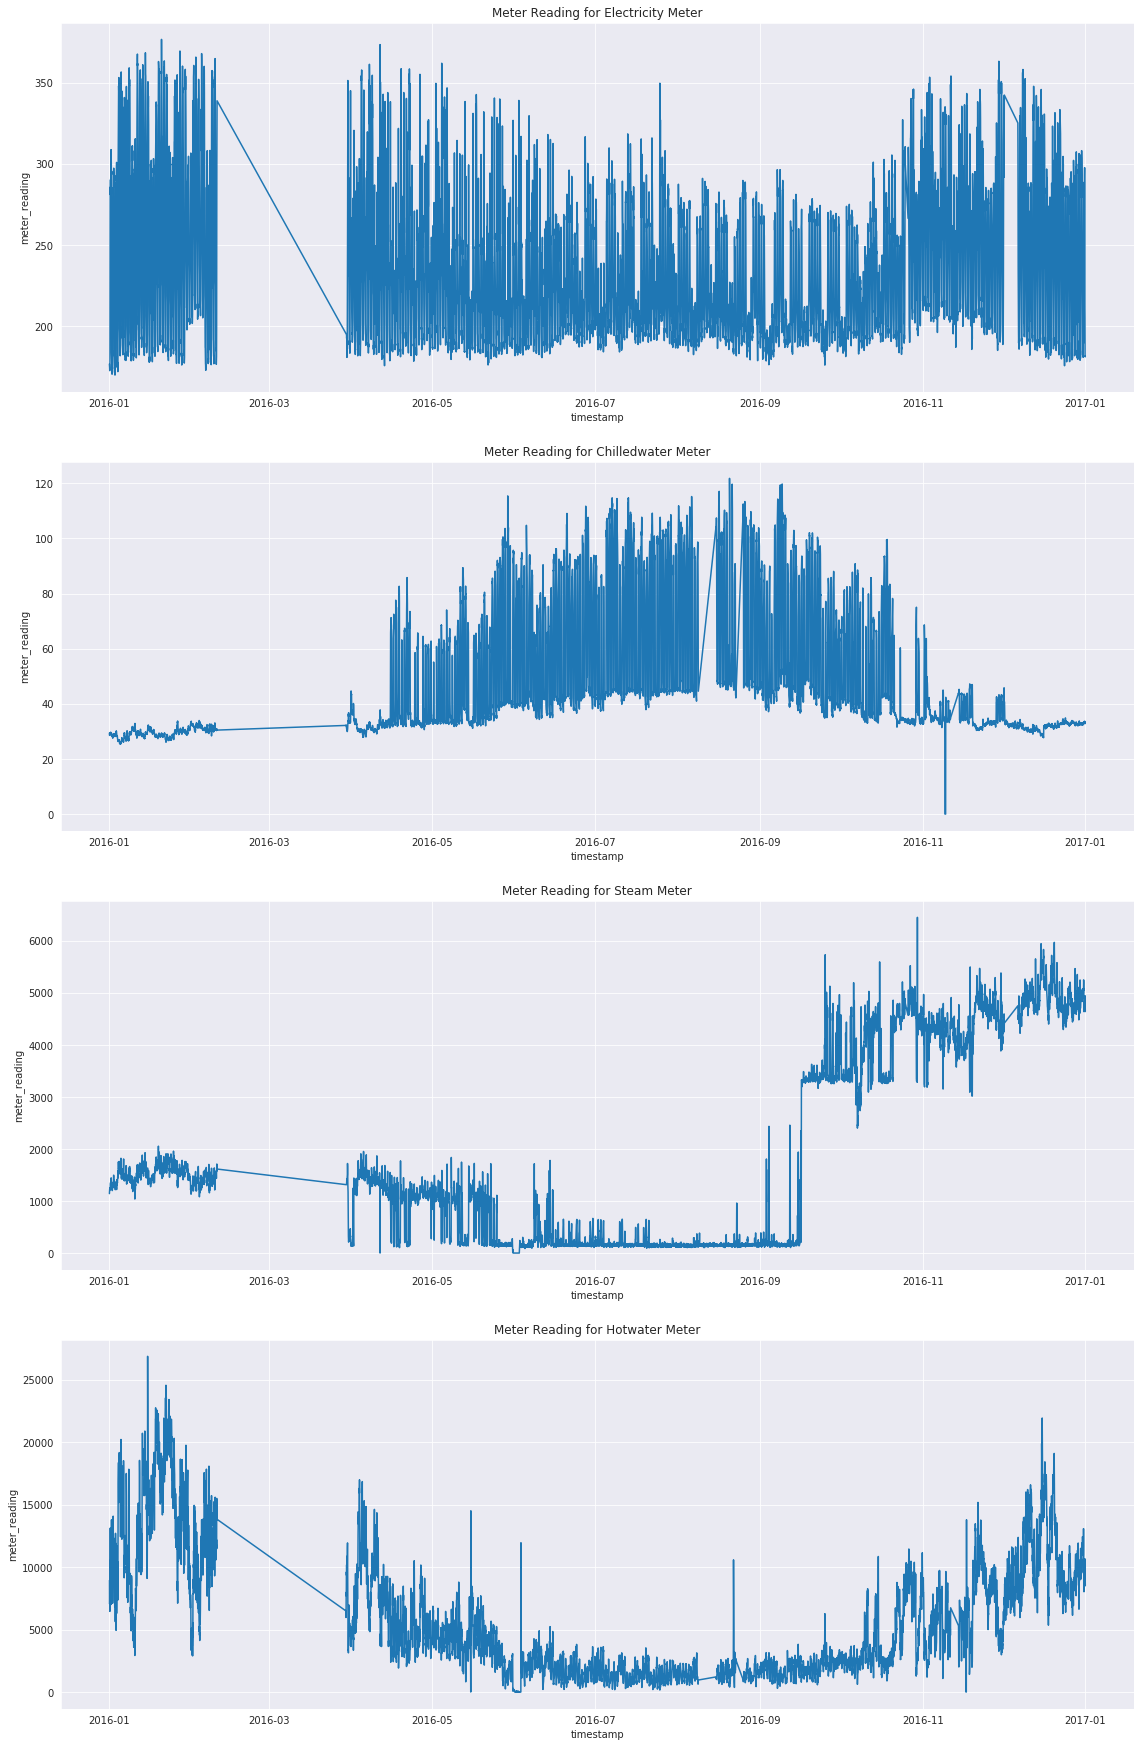

In [34]:
df_temp = df_train[df_train['building_id']==1331]
fig = plt.figure(figsize=(16, 16))

ax1 = fig.add_subplot(411)
df = df_temp[df_temp['meter']==0]
sns.lineplot(x=df['timestamp'], y=df['meter_reading'], ax=ax1)
ax2 = fig.add_subplot(412)
df = df_temp[df_temp['meter']==1]
sns.lineplot(x=df['timestamp'], y=df['meter_reading'], ax=ax2)
ax3 = fig.add_subplot(413)
df = df_temp[df_temp['meter']==2]
sns.lineplot(x=df['timestamp'], y=df['meter_reading'], ax=ax3)
ax4 = fig.add_subplot(414)
df = df_temp[df_temp['meter']==3]
sns.lineplot(x=df['timestamp'], y=df['meter_reading'], ax=ax4)

plt.tight_layout()
plt.subplots_adjust(top=1.5)
ax1.title.set_text('Meter Reading for Electricity Meter')
ax2.title.set_text('Meter Reading for Chilledwater Meter')
ax3.title.set_text('Meter Reading for Steam Meter')
ax4.title.set_text('Meter Reading for Hotwater Meter')

plt.show()

__Observations:__

* Their is sudden linear decrease in the electricity meter reading from Feburary mid to April mid, this suggest their might be a meter fault.
* Chilled water reading meter reading reamains constant from Feburary mid to April mid
* Steam meter reading again shows a linear decrease from Feburary mid to April mid
* Their is sudden linear decrease in the hot water reading from Feburary mid to April mid.

Above points indicates their might be something going on in bulding 1331 from Feburary mid to April mid.


__From the above two plots it is very clear thatt energy consumption pattern of different buildings are very different from each other__

### Let's take a more deeper look on building data

__Let's take a look on the age of buildings.__

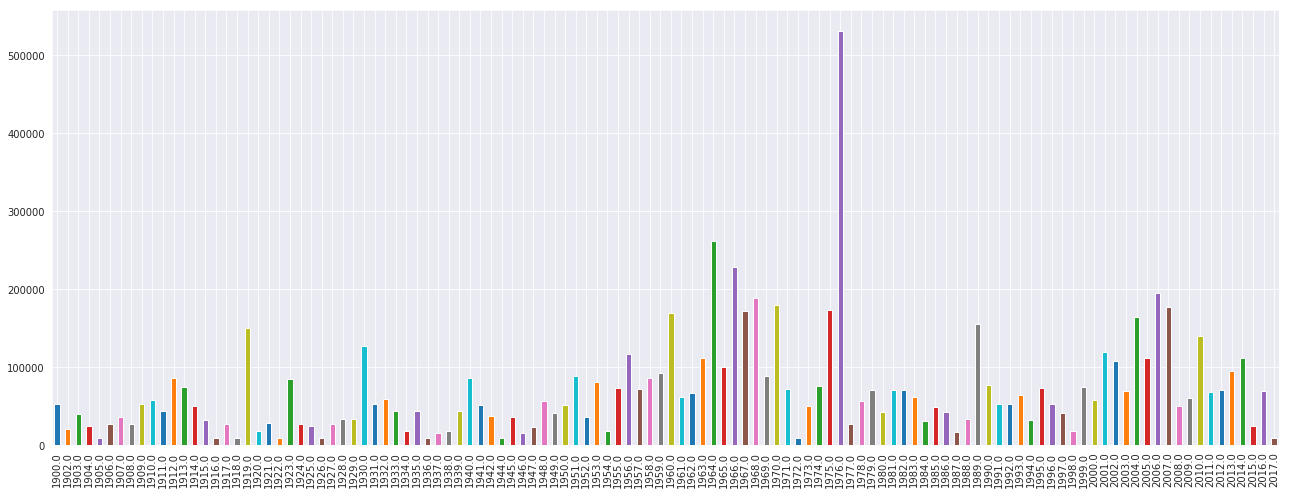

In [35]:
fig = plt.figure(figsize=(22, 8))
df_train['year_built'].value_counts().sort_index().plot.bar(color=color)
plt.show()

__We have the building built in the year 1900(OMG!! More than 110 years old), most of the buildings were made drring 60s and 70s__.

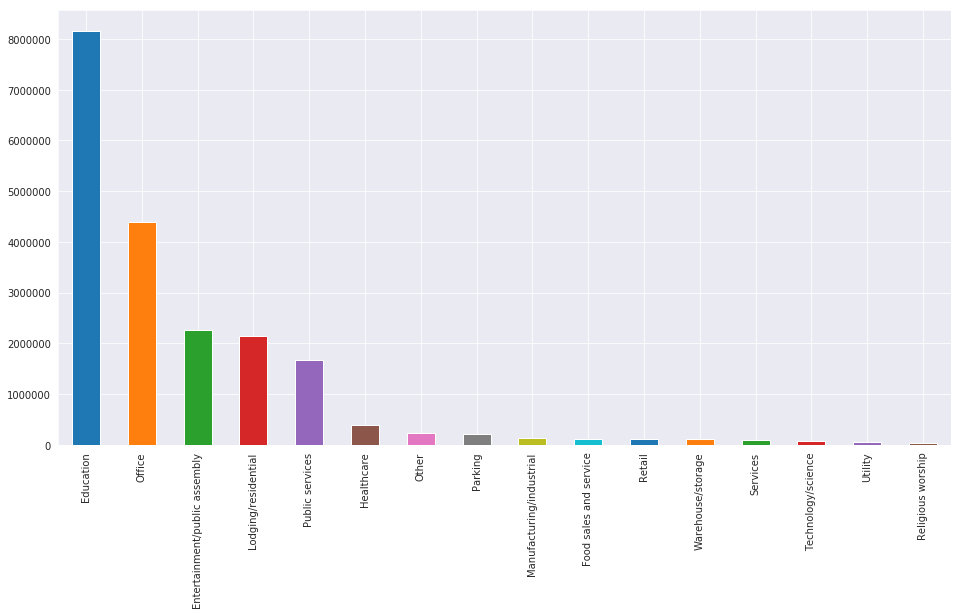

In [36]:
fig = plt.figure(figsize=(16, 8))
df_train['primary_use'].value_counts(dropna=False).plot.bar(color=color)
plt.show()

__Most of buildings in the dataset are built for Educational Purpose followed by Offical and Entetaniment use.__

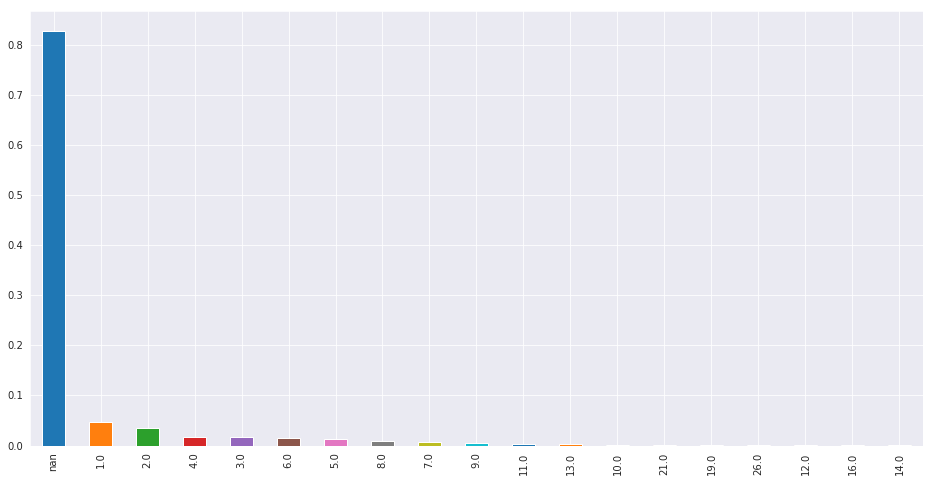

In [37]:
fig = plt.figure(figsize=(16, 8))
df_train['floor_count'].value_counts(normalize=True, dropna=False).plot.bar(color=color)
plt.show()

__Floor information for around 85% of the buildinds in our dataset dosen't have any floorr count__

In [38]:
print("Smallest building Area: ", df_train['square_feet'].min())
print("largetst building Area: ", df_train['square_feet'].max())
print("Mean building Area: ", df_train['square_feet'].mean())
print("Median building Area: ", df_train['square_feet'].median())

Smallest building Area:  283
largetst building Area:  875000
Mean building Area:  107782.98133042477
Median building Area:  72709.0


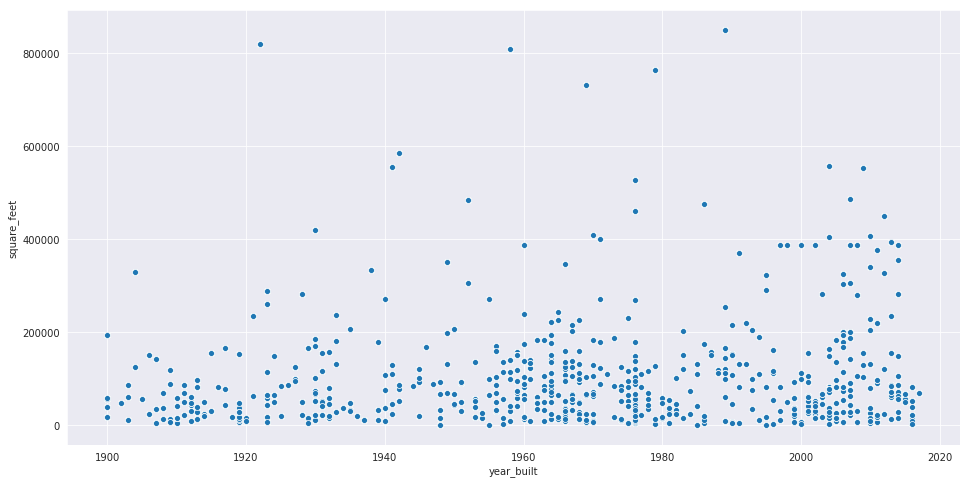

In [39]:
fig = plt.figure(figsize=(16, 8))
sns.scatterplot(x=df_train['year_built'], y=df_train['square_feet'])
plt.show()

__We can see some buildings are quite big__

### Let's explore the weather data

In [40]:
df_weather_train.shape

(139773, 9)

__We have around 0.13 M datapoints for weather dataset__.

In [41]:
df_weather_train.isnull().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

__Let's check the didtribution of Air Temprature over the entire dataset.__

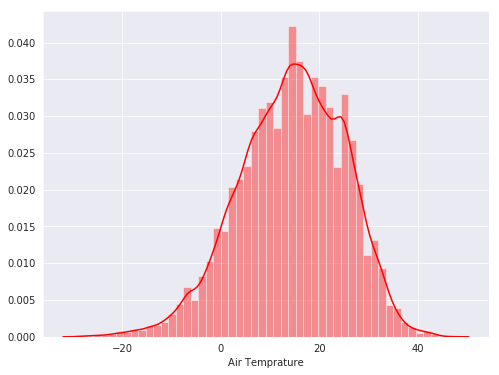

In [42]:
fig = plt.figure(figsize=(8,6))
sns.distplot(df_weather_train['air_temperature'].dropna(), color='red', axlabel="Air Temprature")
plt.show()

__Distribution of Dew Temprature over the entire weather dataset__

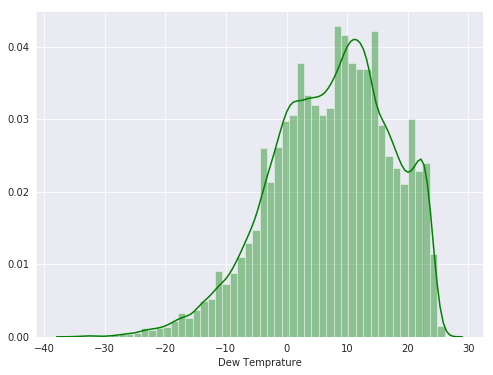

In [43]:
fig = plt.figure(figsize=(8,6))
sns.distplot(df_weather_train['dew_temperature'].dropna(), color='green', axlabel="Dew Temprature")
plt.show()

__Distribution of Sea Level Pressure over the entire weather dataset__

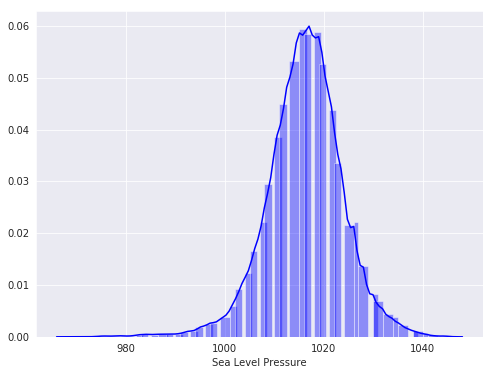

In [44]:
fig = plt.figure(figsize=(8,6))
sns.distplot(df_weather_train['sea_level_pressure'].dropna(), color='blue', axlabel="Sea Level Pressure")
plt.show()

__Distribution of Wind Speed over the entire weather dataset__

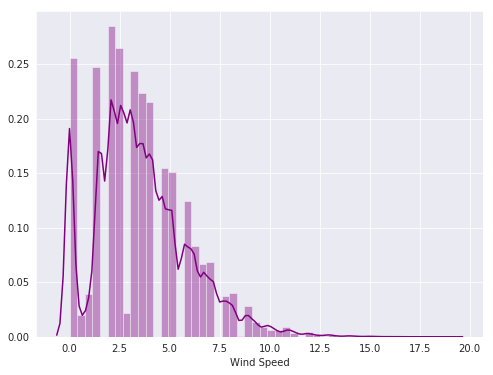

In [45]:
fig = plt.figure(figsize=(8,6))
sns.distplot(df_weather_train['wind_speed'].dropna(), color='purple', axlabel="Wind Speed")
plt.show()

__Cloud coverage information of majority of datapoints in the dataset is missing__.
__Also, significantly large number of infomation regarding Precepitation Depth is missing__.

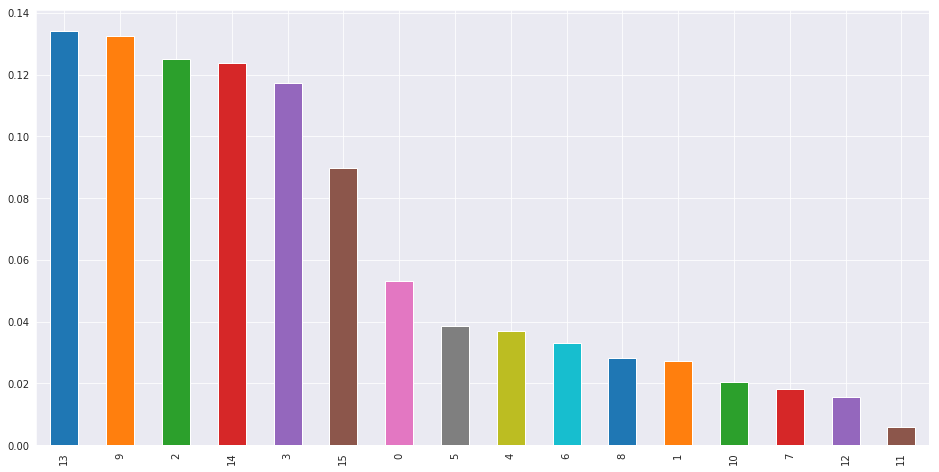

In [46]:
fig = plt.figure(figsize=(16,8))
df_train['site_id'].value_counts(normalize=True, dropna=False).plot.bar(color=color)
plt.show()

__Majority of entries in our dataset is from site 13, 9  & 2__

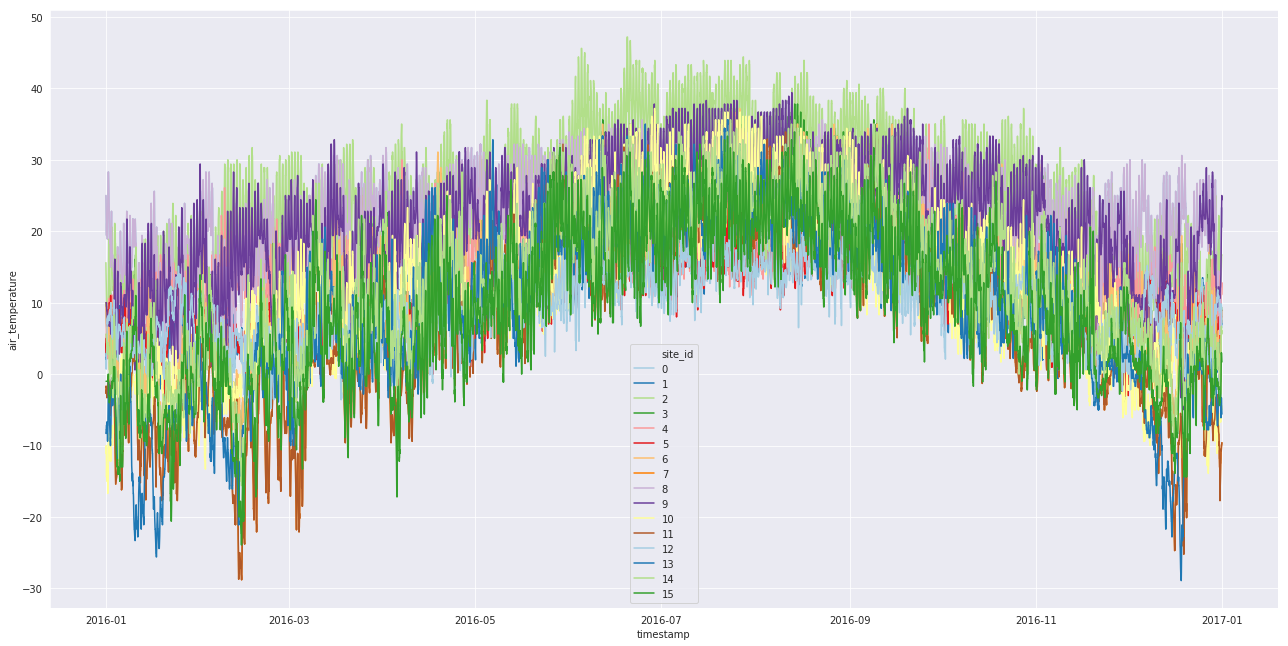

In [47]:
fig = plt.figure(figsize=(22,11))
sns.lineplot(x=df_weather_train['timestamp'], y=df_weather_train['air_temperature'], hue=df_weather_train['site_id'], 
             legend='full', palette=sns.color_palette('Paired',16))
plt.show()

__Temprature range differs at different sites but all of them follows a common pattern the temprature increases till the mid of year and then starts decreasing__.

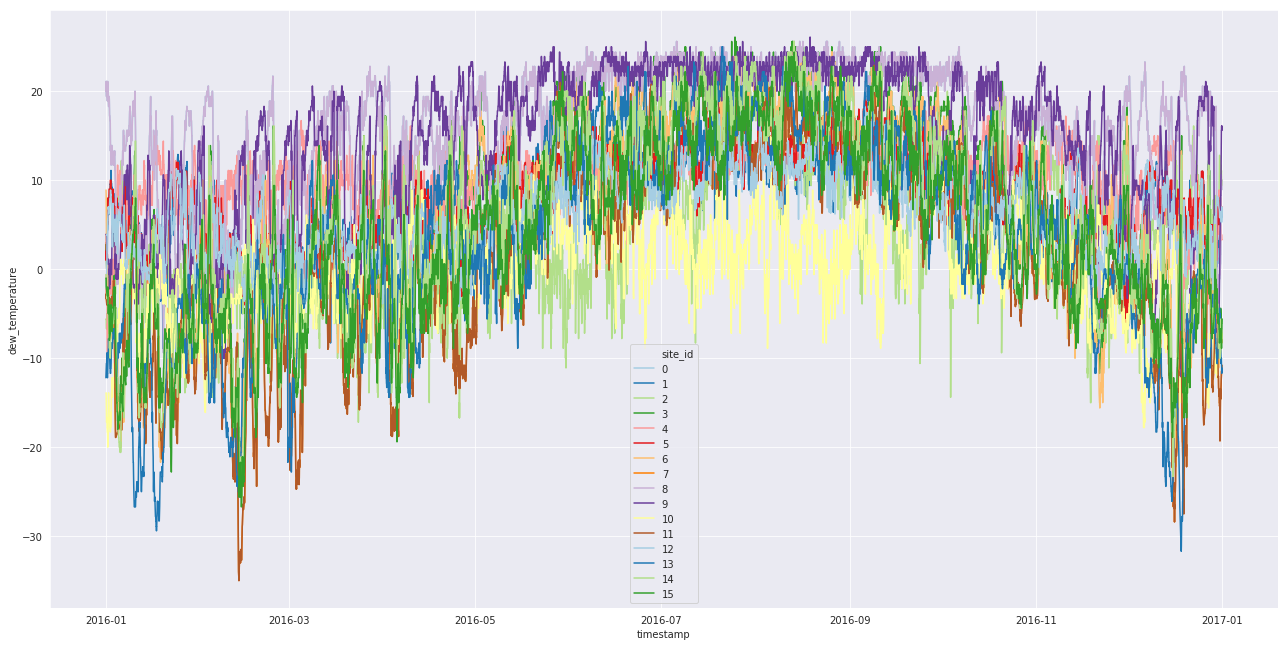

In [48]:
fig = plt.figure(figsize=(22,11))
sns.lineplot(x=df_weather_train['timestamp'], y=df_weather_train['dew_temperature'], hue=df_weather_train['site_id'], 
             legend='full', palette=sns.color_palette('Paired',16))
plt.show()

__Similar to Temprature, Dew Point Temprature among all the sites follows similar rise and fall trend__

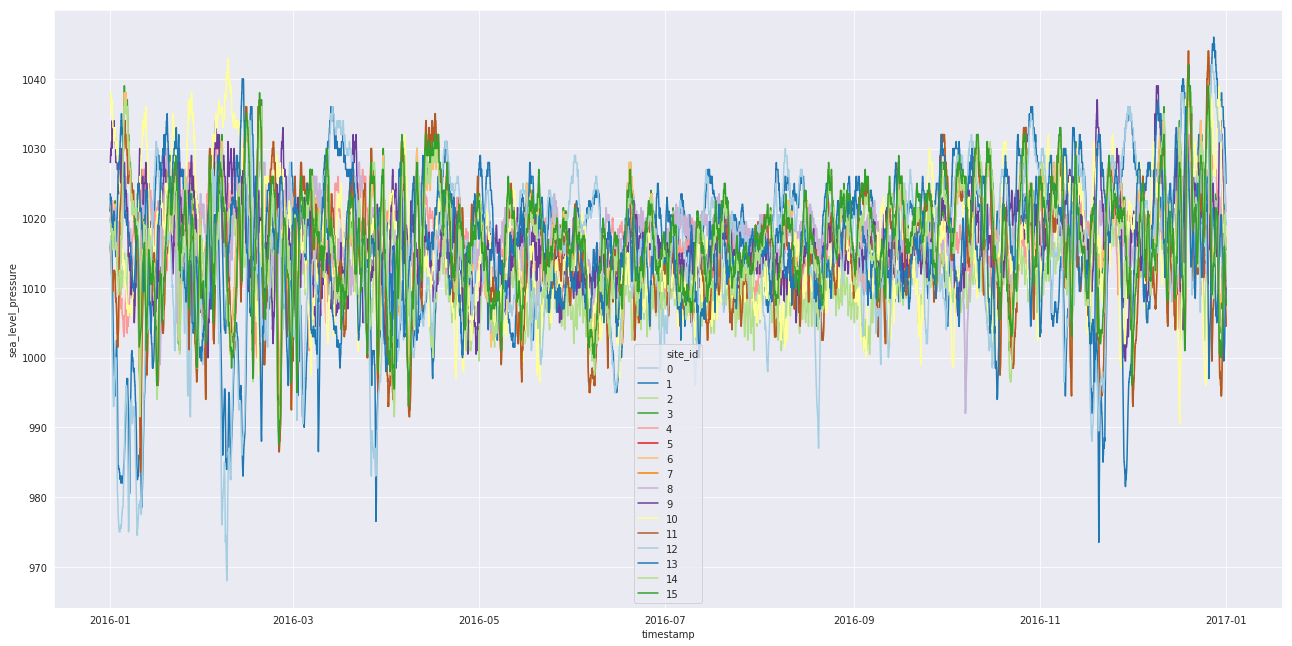

In [49]:
fig = plt.figure(figsize=(22,11))
sns.lineplot(x=df_weather_train['timestamp'], y=df_weather_train['sea_level_pressure'], hue=df_weather_train['site_id'], 
             legend='full', palette=sns.color_palette('Paired',16))
plt.show()

__Sea Level range differs at different sites but all of them follows a common pattern it becomed minimal during the mid of year__.

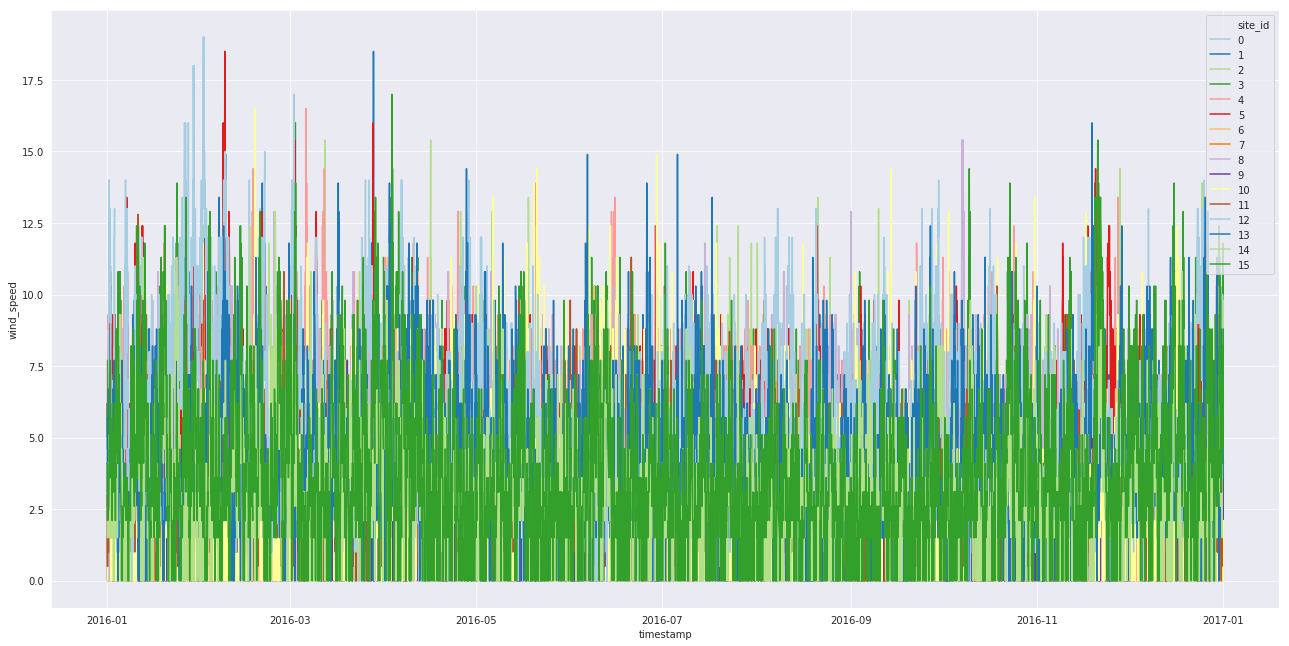

In [50]:
fig = plt.figure(figsize=(22,11))
sns.lineplot(x=df_weather_train['timestamp'], y=df_weather_train['wind_speed'], hue=df_weather_train['site_id'], 
             legend='full', palette=sns.color_palette('Paired',16))
plt.show()

__Wind Speed among all the sites follows a similar trend__